# HW07: Clustering Analysis

## 1. Setup and Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

np.random.seed(42)

In [6]:
# Create directory structure
Path('artifacts/figures').mkdir(parents=True, exist_ok=True)
Path('artifacts/labels').mkdir(parents=True, exist_ok=True)
Path('data').mkdir(exist_ok=True)

print("Directory structure created successfully")

Directory structure created successfully


## 2. Helper Functions

In [7]:
def compute_metrics(X, labels, algorithm_name=''):
    """
    Compute clustering metrics excluding noise points for DBSCAN.
    """
    mask = labels != -1
    X_filtered = X[mask]
    labels_filtered = labels[mask]
    
    n_clusters = len(set(labels_filtered))
    noise_ratio = np.sum(labels == -1) / len(labels)
    
    if n_clusters < 2 or len(labels_filtered) < 2:
        return {
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio
        }
    
    sil = silhouette_score(X_filtered, labels_filtered)
    db = davies_bouldin_score(X_filtered, labels_filtered)
    ch = calinski_harabasz_score(X_filtered, labels_filtered)
    
    return {
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio
    }

def plot_clusters_pca(X, labels, title, save_path=None):
    """
    Plot clusters using PCA 2D projection.
    """
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', 
                         alpha=0.6, edgecolors='k', linewidth=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
    plt.title(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
def save_labels(sample_ids, labels, filename):
    """
    Save cluster labels to CSV.
    """
    df = pd.DataFrame({
        'sample_id': sample_ids,
        'cluster_label': labels
    })
    df.to_csv(filename, index=False)
    print(f"Labels saved to {filename}")

## 3. Dataset 02: Nonlinear Structure + Outliers

This dataset features nonlinear cluster boundaries and outliers, making it challenging for KMeans.

### 3.1. Load and EDA

In [8]:
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')

print("Dataset 02 - Shape:", df2.shape)
print("\nFirst rows:")
display(df2.head())

print("\nData types:")
print(df2.dtypes)

print("\nMissing values:")
print(df2.isnull().sum())

print("\nBasic statistics:")
display(df2.describe())

Dataset 02 - Shape: (8000, 4)

First rows:


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



Data types:
sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object

Missing values:
sample_id    0
x1           0
x2           0
z_noise      0
dtype: int64

Basic statistics:


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [9]:
sample_ids_2 = df2['sample_id'].values
X2 = df2.drop(columns=['sample_id']).values
feature_names_2 = df2.drop(columns=['sample_id']).columns.tolist()

print(f"Features: {feature_names_2}")
print(f"Shape: {X2.shape}")

Features: ['x1', 'x2', 'z_noise']
Shape: (8000, 3)


### 3.2. Preprocessing

In [10]:
scaler_2 = StandardScaler()
X2_scaled = scaler_2.fit_transform(X2)

print(f"Scaled data shape: {X2_scaled.shape}")
print(f"Mean: {X2_scaled.mean(axis=0)}")
print(f"Std: {X2_scaled.std(axis=0)}")

Scaled data shape: (8000, 3)
Mean: [-3.55271368e-18  5.15143483e-17 -8.88178420e-18]
Std: [1. 1. 1.]


### 3.3. KMeans - Hyperparameter Search

In [11]:
k_range = range(2, 21)
kmeans_results_2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X2_scaled)
    metrics = compute_metrics(X2_scaled, labels)
    
    kmeans_results_2.append({
        'k': k,
        'silhouette': metrics['silhouette'],
        'davies_bouldin': metrics['davies_bouldin'],
        'calinski_harabasz': metrics['calinski_harabasz'],
        'inertia': kmeans.inertia_
    })

df_kmeans_2 = pd.DataFrame(kmeans_results_2)
display(df_kmeans_2.head(10))

,k,silhouette,davies_bouldin,calinski_harabasz,inertia
0,2,0.306861,1.323472,3573.393333,16588.501032
1,3,0.270045,1.222659,3082.272075,13552.940683
2,4,0.251481,1.299819,2915.565357,11461.979866
3,5,0.252115,1.213834,2703.589704,10201.497627
4,6,0.259820,1.159521,2571.090931,9201.991536
5,7,0.253643,1.172334,2453.500966,8445.556094
6,8,0.252305,1.100178,2408.516587,7718.175647
7,9,0.252463,1.089569,2379.989955,7095.112464
8,10,0.260869,1.057142,2408.192011,6464.489059
9,11,0.265944,1.025115,2361.200917,6067.528490


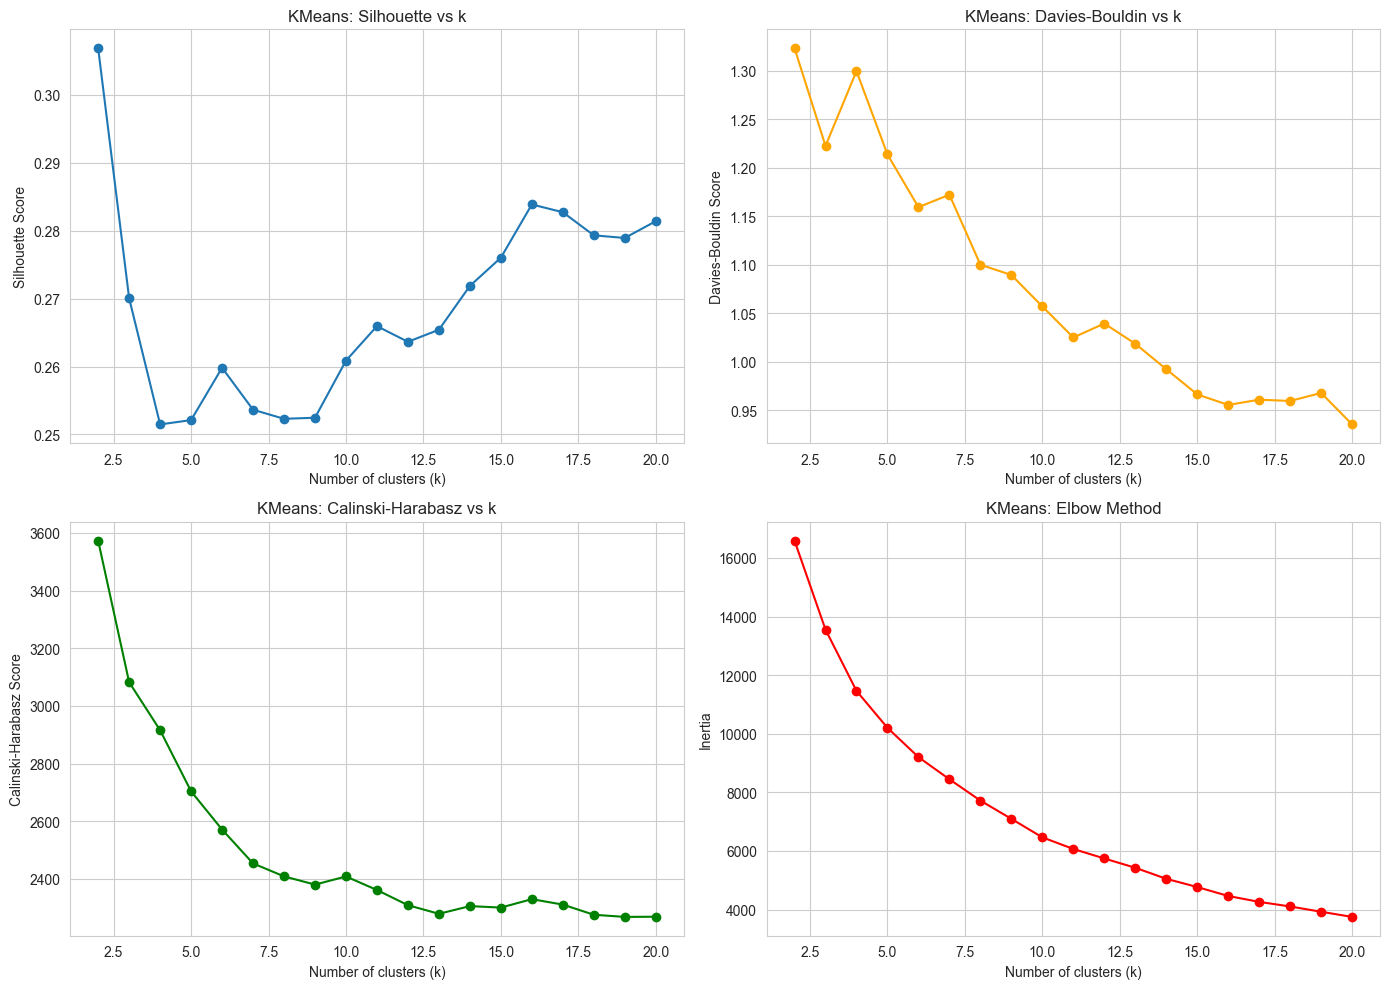

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(df_kmeans_2['k'], df_kmeans_2['silhouette'], 'o-')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('KMeans: Silhouette vs k')
axes[0, 0].grid(True)

axes[0, 1].plot(df_kmeans_2['k'], df_kmeans_2['davies_bouldin'], 'o-', color='orange')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Score')
axes[0, 1].set_title('KMeans: Davies-Bouldin vs k')
axes[0, 1].grid(True)

axes[1, 0].plot(df_kmeans_2['k'], df_kmeans_2['calinski_harabasz'], 'o-', color='green')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('KMeans: Calinski-Harabasz vs k')
axes[1, 0].grid(True)

axes[1, 1].plot(df_kmeans_2['k'], df_kmeans_2['inertia'], 'o-', color='red')
axes[1, 1].set_xlabel('Number of clusters (k)')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('KMeans: Elbow Method')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds02_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
best_k_2 = df_kmeans_2.loc[df_kmeans_2['silhouette'].idxmax(), 'k']
print(f"Best k (by silhouette): {best_k_2}")

kmeans_best_2 = KMeans(n_clusters=int(best_k_2), random_state=42, n_init=10)
labels_kmeans_2 = kmeans_best_2.fit_predict(X2_scaled)

metrics_kmeans_2 = compute_metrics(X2_scaled, labels_kmeans_2)
print(f"\nKMeans metrics (k={best_k_2}):")
for key, val in metrics_kmeans_2.items():
    print(f"  {key}: {val}")

Best k (by silhouette): 2

KMeans metrics (k=2):
  silhouette: 0.3068610017701601
  davies_bouldin: 1.3234721699867644
  calinski_harabasz: 3573.3933329348392
  n_clusters: 2
  noise_ratio: 0.0


### 3.4. DBSCAN - Hyperparameter Search

In [14]:
eps_range = np.linspace(0.3, 2.0, 10)
min_samples_range = [3, 5, 10]

dbscan_results_2 = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X2_scaled)
        metrics = compute_metrics(X2_scaled, labels)
        
        dbscan_results_2.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette': metrics['silhouette'],
            'davies_bouldin': metrics['davies_bouldin'],
            'calinski_harabasz': metrics['calinski_harabasz'],
            'n_clusters': metrics['n_clusters'],
            'noise_ratio': metrics['noise_ratio']
        })

df_dbscan_2 = pd.DataFrame(dbscan_results_2)
df_dbscan_2_valid = df_dbscan_2[df_dbscan_2['n_clusters'] >= 2].copy()

display(df_dbscan_2_valid.head(10))

,eps,min_samples,silhouette,davies_bouldin,calinski_harabasz,n_clusters,noise_ratio
0,0.300000,3,-0.300620,0.579598,16.826952,30,0.059250
1,0.300000,5,0.085225,0.589699,21.951657,5,0.072375
3,0.488889,3,-0.073447,0.798144,37.450790,34,0.026125
4,0.488889,5,-0.105826,0.755278,44.699069,14,0.047000
5,0.488889,10,0.262166,0.715505,24.775317,2,0.064125
6,0.677778,3,0.346366,0.550416,10.446509,2,0.008125
7,0.677778,5,0.327368,0.672351,19.237906,2,0.011250
8,0.677778,10,0.328454,0.623000,135.627647,5,0.041875


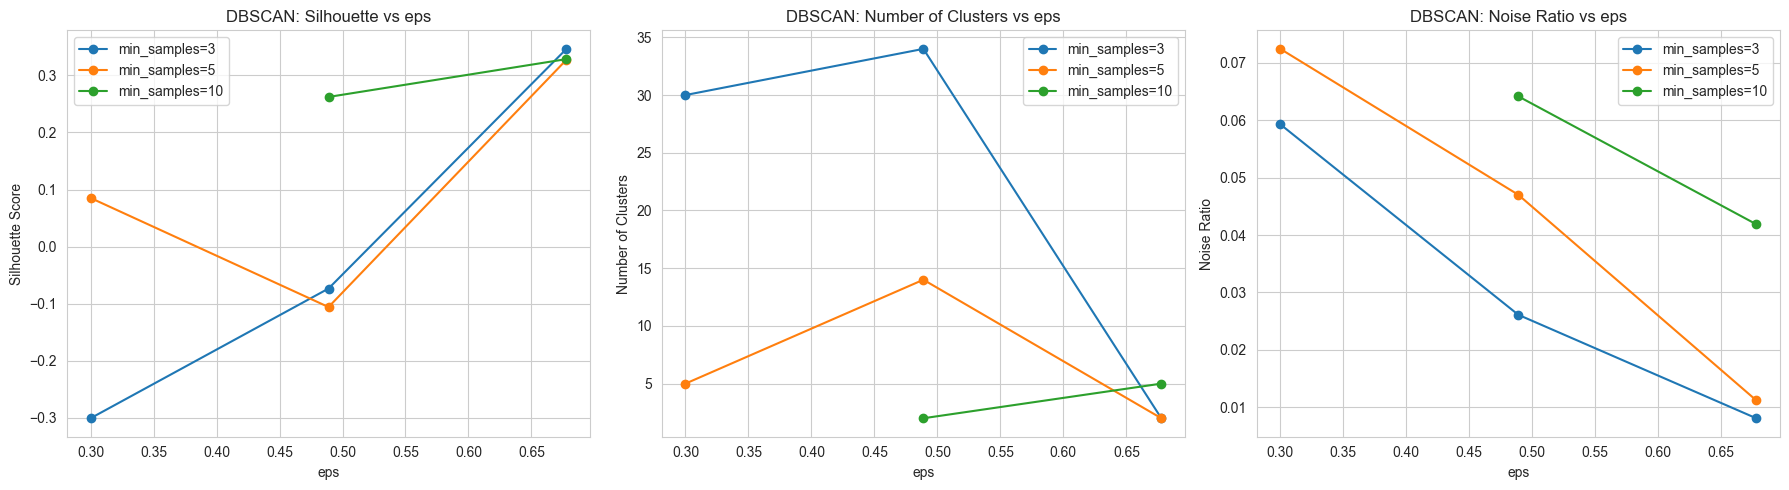

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for min_samp in min_samples_range:
    subset = df_dbscan_2_valid[df_dbscan_2_valid['min_samples'] == min_samp]
    axes[0].plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_samples={min_samp}')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('DBSCAN: Silhouette vs eps')
axes[0].legend()
axes[0].grid(True)

for min_samp in min_samples_range:
    subset = df_dbscan_2_valid[df_dbscan_2_valid['min_samples'] == min_samp]
    axes[1].plot(subset['eps'], subset['n_clusters'], 'o-', label=f'min_samples={min_samp}')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('Number of Clusters')
axes[1].set_title('DBSCAN: Number of Clusters vs eps')
axes[1].legend()
axes[1].grid(True)

for min_samp in min_samples_range:
    subset = df_dbscan_2_valid[df_dbscan_2_valid['min_samples'] == min_samp]
    axes[2].plot(subset['eps'], subset['noise_ratio'], 'o-', label=f'min_samples={min_samp}')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('Noise Ratio')
axes[2].set_title('DBSCAN: Noise Ratio vs eps')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds02_dbscan_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
best_idx_2 = df_dbscan_2_valid['silhouette'].idxmax()
best_eps_2 = df_dbscan_2_valid.loc[best_idx_2, 'eps']
best_min_samples_2 = df_dbscan_2_valid.loc[best_idx_2, 'min_samples']

print(f"Best DBSCAN params: eps={best_eps_2:.2f}, min_samples={int(best_min_samples_2)}")

dbscan_best_2 = DBSCAN(eps=best_eps_2, min_samples=int(best_min_samples_2))
labels_dbscan_2 = dbscan_best_2.fit_predict(X2_scaled)

metrics_dbscan_2 = compute_metrics(X2_scaled, labels_dbscan_2)
print(f"\nDBSCAN metrics:")
for key, val in metrics_dbscan_2.items():
    print(f"  {key}: {val}")

Best DBSCAN params: eps=0.68, min_samples=3

DBSCAN metrics:
  silhouette: 0.3463660465876595
  davies_bouldin: 0.5504155711879929
  calinski_harabasz: 10.44650944206373
  n_clusters: 2
  noise_ratio: 0.008125


### 3.5. Visualization and Best Model Selection

In [17]:
print("Comparison for Dataset 02:")
print(f"\nKMeans (k={best_k_2}):")
print(f"  Silhouette: {metrics_kmeans_2['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_kmeans_2['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_kmeans_2['calinski_harabasz']:.2f}")

print(f"\nDBSCAN (eps={best_eps_2:.2f}, min_samples={int(best_min_samples_2)}):")
print(f"  Silhouette: {metrics_dbscan_2['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_dbscan_2['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_dbscan_2['calinski_harabasz']:.2f}")
print(f"  Noise ratio: {metrics_dbscan_2['noise_ratio']:.4f}")
print(f"  Number of clusters: {metrics_dbscan_2['n_clusters']}")

Comparison for Dataset 02:

KMeans (k=2):
  Silhouette: 0.3069
  Davies-Bouldin: 1.3235
  Calinski-Harabasz: 3573.39

DBSCAN (eps=0.68, min_samples=3):
  Silhouette: 0.3464
  Davies-Bouldin: 0.5504
  Calinski-Harabasz: 10.45
  Noise ratio: 0.0081
  Number of clusters: 2


In [18]:
if metrics_dbscan_2['silhouette'] > metrics_kmeans_2['silhouette']:
    best_method_2 = 'DBSCAN'
    best_labels_2 = labels_dbscan_2
    best_params_2 = {'eps': best_eps_2, 'min_samples': int(best_min_samples_2)}
else:
    best_method_2 = 'KMeans'
    best_labels_2 = labels_kmeans_2
    best_params_2 = {'k': int(best_k_2)}

print(f"\nBest method for Dataset 02: {best_method_2}")
print(f"Best parameters: {best_params_2}")


Best method for Dataset 02: DBSCAN
Best parameters: {'eps': np.float64(0.6777777777777778), 'min_samples': 3}


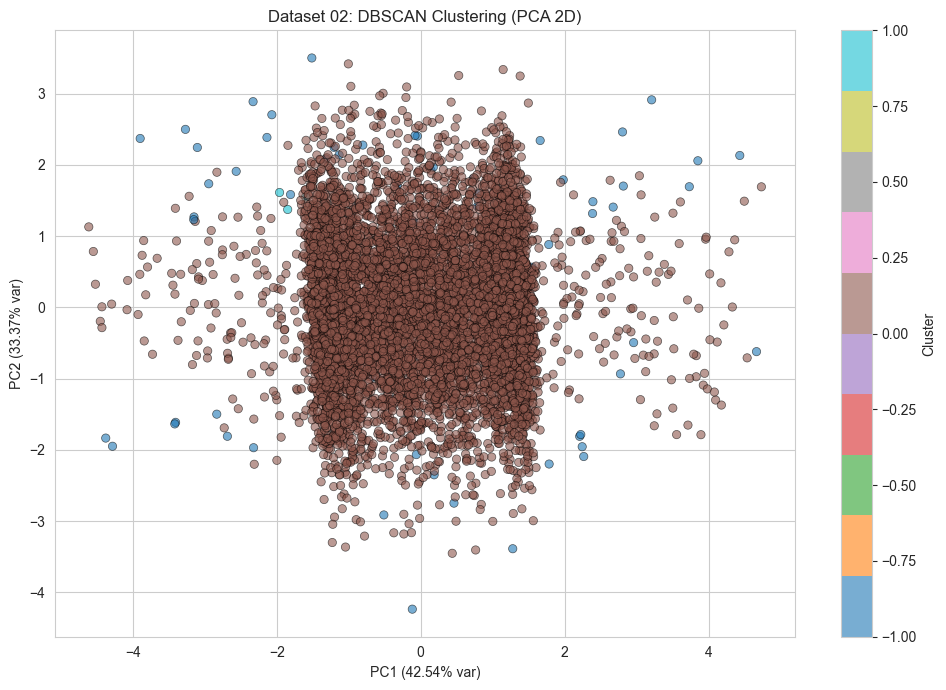

In [19]:
plot_clusters_pca(
    X2_scaled, 
    best_labels_2,
    f'Dataset 02: {best_method_2} Clustering (PCA 2D)',
    'artifacts/figures/ds02_best_clusters.png'
)

In [20]:
save_labels(sample_ids_2, best_labels_2, 'artifacts/labels/labels_hw07_ds02.csv')

Labels saved to artifacts/labels/labels_hw07_ds02.csv


### 3.6. Stability Analysis for Dataset 02

In [21]:
print("Stability analysis: KMeans with different random_state values")

random_states = [42, 123, 456, 789, 1011]
all_labels = []

for rs in random_states:
    kmeans_temp = KMeans(n_clusters=int(best_k_2), random_state=rs, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X2_scaled)
    all_labels.append(labels_temp)

ari_scores = []
for i in range(len(all_labels)):
    for j in range(i+1, len(all_labels)):
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_scores.append(ari)

print(f"\nAdjusted Rand Index between runs:")
print(f"  Mean ARI: {np.mean(ari_scores):.4f}")
print(f"  Std ARI: {np.std(ari_scores):.4f}")
print(f"  Min ARI: {np.min(ari_scores):.4f}")
print(f"  Max ARI: {np.max(ari_scores):.4f}")

if np.mean(ari_scores) > 0.9:
    print("\nConclusion: Clustering is highly stable across different initializations.")
elif np.mean(ari_scores) > 0.7:
    print("\nConclusion: Clustering is moderately stable.")
else:
    print("\nConclusion: Clustering shows instability across different initializations.")

Stability analysis: KMeans with different random_state values

Adjusted Rand Index between runs:
  Mean ARI: 0.9981
  Std ARI: 0.0010
  Min ARI: 0.9965
  Max ARI: 0.9995

Conclusion: Clustering is highly stable across different initializations.


## 4. Dataset 03: Variable Density Clusters

This dataset contains clusters with different densities and background noise.

### 4.1. Load and EDA

In [22]:
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')

print("Dataset 03 - Shape:", df3.shape)
print("\nFirst rows:")
display(df3.head())

print("\nData types:")
print(df3.dtypes)

print("\nMissing values:")
print(df3.isnull().sum())

print("\nBasic statistics:")
display(df3.describe())

Dataset 03 - Shape: (15000, 5)

First rows:


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899



Data types:
sample_id      int64
x1           float64
x2           float64
f_corr       float64
f_noise      float64
dtype: object

Missing values:
sample_id    0
x1           0
x2           0
f_corr       0
f_noise      0
dtype: int64

Basic statistics:


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [23]:
sample_ids_3 = df3['sample_id'].values
X3 = df3.drop(columns=['sample_id']).values
feature_names_3 = df3.drop(columns=['sample_id']).columns.tolist()

print(f"Features: {feature_names_3}")
print(f"Shape: {X3.shape}")

Features: ['x1', 'x2', 'f_corr', 'f_noise']
Shape: (15000, 4)


### 4.2. Preprocessing

In [24]:
scaler_3 = StandardScaler()
X3_scaled = scaler_3.fit_transform(X3)

print(f"Scaled data shape: {X3_scaled.shape}")
print(f"Mean: {X3_scaled.mean(axis=0)}")
print(f"Std: {X3_scaled.std(axis=0)}")

Scaled data shape: (15000, 4)
Mean: [ 0.00000000e+00 -3.03164901e-17  0.00000000e+00 -8.52651283e-18]
Std: [1. 1. 1. 1.]


### 4.3. KMeans - Hyperparameter Search

In [25]:
k_range = range(2, 21)
kmeans_results_3 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X3_scaled)
    metrics = compute_metrics(X3_scaled, labels)
    
    kmeans_results_3.append({
        'k': k,
        'silhouette': metrics['silhouette'],
        'davies_bouldin': metrics['davies_bouldin'],
        'calinski_harabasz': metrics['calinski_harabasz'],
        'inertia': kmeans.inertia_
    })

df_kmeans_3 = pd.DataFrame(kmeans_results_3)
display(df_kmeans_3.head(10))

,k,silhouette,davies_bouldin,calinski_harabasz,inertia
0,2,0.298905,1.355468,7004.795630,40898.439232
1,3,0.315545,1.157726,6957.162640,31123.461050
2,4,0.314619,1.159676,6492.278931,26100.560538
3,5,0.299297,1.168556,6125.127993,22779.904725
4,6,0.293149,1.140769,6097.475389,19780.457233
5,7,0.279853,1.218465,5858.344907,17940.310306
6,8,0.289491,1.147231,5630.838101,16532.946561
7,9,0.284791,1.123538,5543.965528,15157.053517
8,10,0.278895,1.143786,5386.123819,14171.652185
9,11,0.276319,1.142855,5207.368057,13410.477000


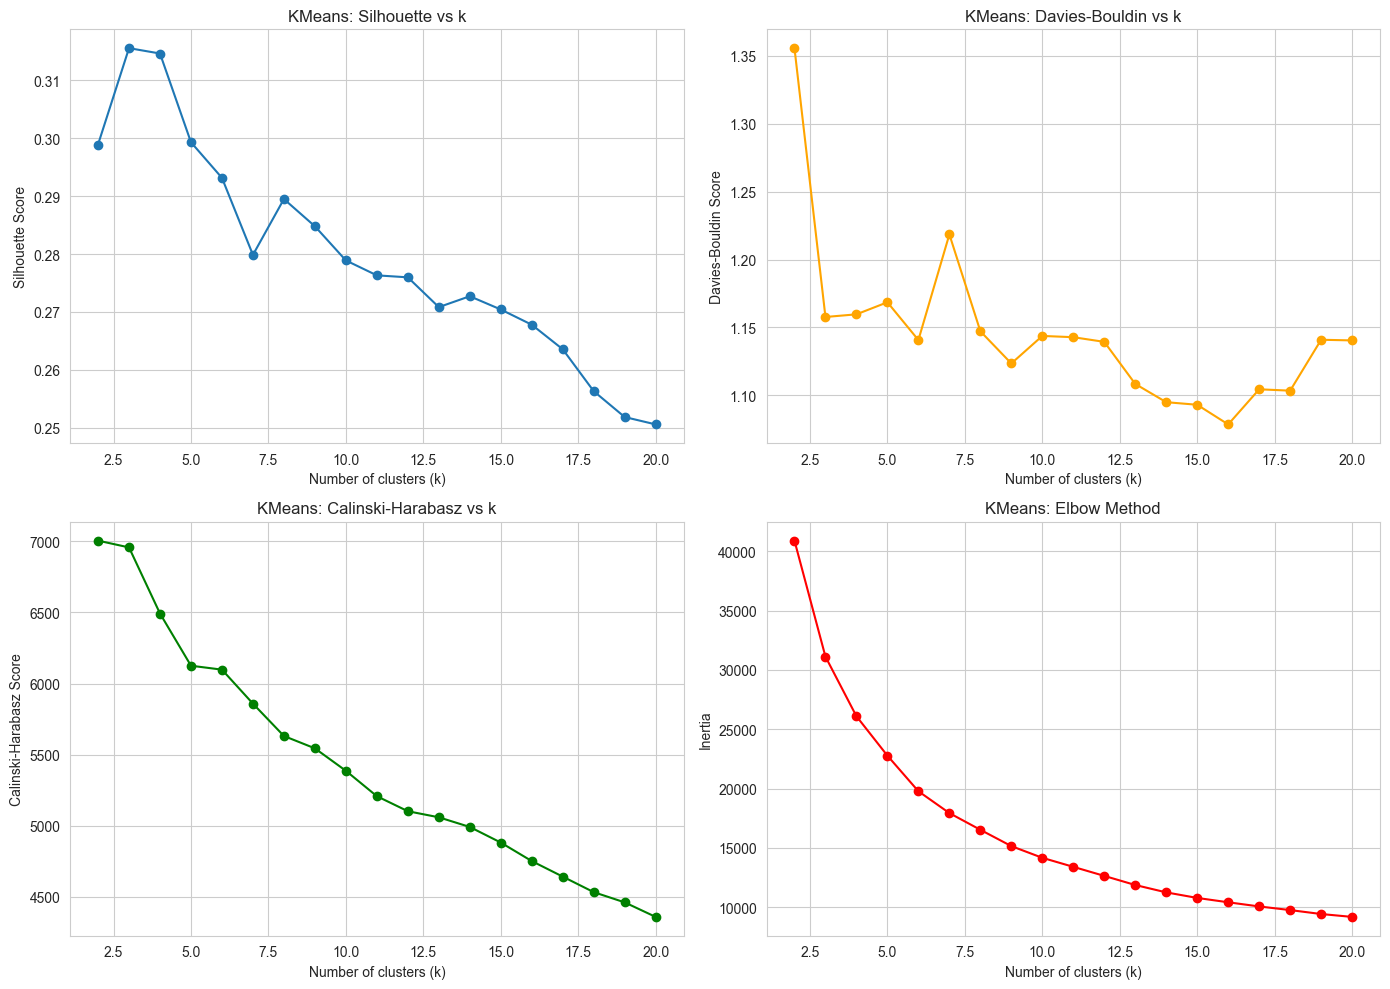

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(df_kmeans_3['k'], df_kmeans_3['silhouette'], 'o-')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('KMeans: Silhouette vs k')
axes[0, 0].grid(True)

axes[0, 1].plot(df_kmeans_3['k'], df_kmeans_3['davies_bouldin'], 'o-', color='orange')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Score')
axes[0, 1].set_title('KMeans: Davies-Bouldin vs k')
axes[0, 1].grid(True)

axes[1, 0].plot(df_kmeans_3['k'], df_kmeans_3['calinski_harabasz'], 'o-', color='green')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('KMeans: Calinski-Harabasz vs k')
axes[1, 0].grid(True)

axes[1, 1].plot(df_kmeans_3['k'], df_kmeans_3['inertia'], 'o-', color='red')
axes[1, 1].set_xlabel('Number of clusters (k)')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('KMeans: Elbow Method')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds03_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
best_k_3 = df_kmeans_3.loc[df_kmeans_3['silhouette'].idxmax(), 'k']
print(f"Best k (by silhouette): {best_k_3}")

kmeans_best_3 = KMeans(n_clusters=int(best_k_3), random_state=42, n_init=10)
labels_kmeans_3 = kmeans_best_3.fit_predict(X3_scaled)

metrics_kmeans_3 = compute_metrics(X3_scaled, labels_kmeans_3)
print(f"\nKMeans metrics (k={best_k_3}):")
for key, val in metrics_kmeans_3.items():
    print(f"  {key}: {val}")

Best k (by silhouette): 3

KMeans metrics (k=3):
  silhouette: 0.31554470037825183
  davies_bouldin: 1.1577256320598661
  calinski_harabasz: 6957.162639510166
  n_clusters: 3
  noise_ratio: 0.0


### 4.4. Agglomerative Clustering - Hyperparameter Search

In [28]:
k_range_agg = range(2, 16)
linkage_methods = ['ward', 'complete', 'average']

agg_results_3 = []

for k in k_range_agg:
    for linkage in linkage_methods:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X3_scaled)
        metrics = compute_metrics(X3_scaled, labels)
        
        agg_results_3.append({
            'k': k,
            'linkage': linkage,
            'silhouette': metrics['silhouette'],
            'davies_bouldin': metrics['davies_bouldin'],
            'calinski_harabasz': metrics['calinski_harabasz']
        })

df_agg_3 = pd.DataFrame(agg_results_3)
display(df_agg_3.head(10))

,k,linkage,silhouette,davies_bouldin,calinski_harabasz
0,2,ward,0.292500,1.380807,6680.868002
1,2,complete,0.227077,1.674890,4568.646712
2,2,average,0.425296,0.813802,8.943143
3,3,ward,0.309400,1.177594,6705.577295
4,3,complete,0.146818,1.667585,3300.249860
5,3,average,0.255657,0.965062,78.990588
6,4,ward,0.303572,1.173095,6206.351567
7,4,complete,0.122334,1.637994,3139.168149
8,4,average,0.245980,0.816474,53.940675
9,5,ward,0.274698,1.183392,5558.796175


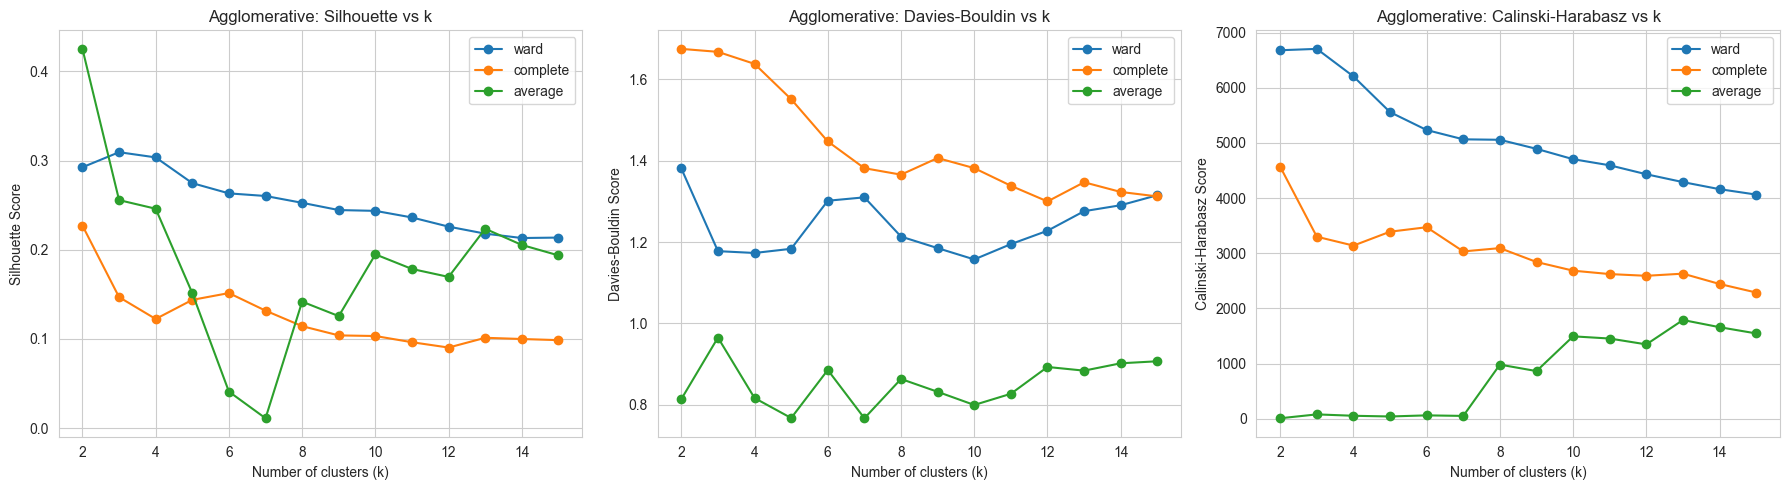

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for linkage in linkage_methods:
    subset = df_agg_3[df_agg_3['linkage'] == linkage]
    axes[0].plot(subset['k'], subset['silhouette'], 'o-', label=linkage)
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Agglomerative: Silhouette vs k')
axes[0].legend()
axes[0].grid(True)

for linkage in linkage_methods:
    subset = df_agg_3[df_agg_3['linkage'] == linkage]
    axes[1].plot(subset['k'], subset['davies_bouldin'], 'o-', label=linkage)
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Agglomerative: Davies-Bouldin vs k')
axes[1].legend()
axes[1].grid(True)

for linkage in linkage_methods:
    subset = df_agg_3[df_agg_3['linkage'] == linkage]
    axes[2].plot(subset['k'], subset['calinski_harabasz'], 'o-', label=linkage)
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Agglomerative: Calinski-Harabasz vs k')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds03_agg_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
best_idx_3 = df_agg_3['silhouette'].idxmax()
best_k_agg_3 = df_agg_3.loc[best_idx_3, 'k']
best_linkage_3 = df_agg_3.loc[best_idx_3, 'linkage']

print(f"Best Agglomerative params: k={best_k_agg_3}, linkage={best_linkage_3}")

agg_best_3 = AgglomerativeClustering(n_clusters=int(best_k_agg_3), linkage=best_linkage_3)
labels_agg_3 = agg_best_3.fit_predict(X3_scaled)

metrics_agg_3 = compute_metrics(X3_scaled, labels_agg_3)
print(f"\nAgglomerative metrics:")
for key, val in metrics_agg_3.items():
    print(f"  {key}: {val}")

Best Agglomerative params: k=2, linkage=average

Agglomerative metrics:
  silhouette: 0.42529612444453263
  davies_bouldin: 0.813802016581118
  calinski_harabasz: 8.9431431155568
  n_clusters: 2
  noise_ratio: 0.0


### 4.5. Visualization and Best Model Selection

In [31]:
print("Comparison for Dataset 03:")
print(f"\nKMeans (k={best_k_3}):")
print(f"  Silhouette: {metrics_kmeans_3['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_kmeans_3['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_kmeans_3['calinski_harabasz']:.2f}")

print(f"\nAgglomerative (k={best_k_agg_3}, linkage={best_linkage_3}):")
print(f"  Silhouette: {metrics_agg_3['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_agg_3['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_agg_3['calinski_harabasz']:.2f}")

Comparison for Dataset 03:

KMeans (k=3):
  Silhouette: 0.3155
  Davies-Bouldin: 1.1577
  Calinski-Harabasz: 6957.16

Agglomerative (k=2, linkage=average):
  Silhouette: 0.4253
  Davies-Bouldin: 0.8138
  Calinski-Harabasz: 8.94


In [32]:
if metrics_agg_3['silhouette'] > metrics_kmeans_3['silhouette']:
    best_method_3 = 'Agglomerative'
    best_labels_3 = labels_agg_3
    best_params_3 = {'k': int(best_k_agg_3), 'linkage': best_linkage_3}
else:
    best_method_3 = 'KMeans'
    best_labels_3 = labels_kmeans_3
    best_params_3 = {'k': int(best_k_3)}

print(f"\nBest method for Dataset 03: {best_method_3}")
print(f"Best parameters: {best_params_3}")


Best method for Dataset 03: Agglomerative
Best parameters: {'k': 2, 'linkage': 'average'}


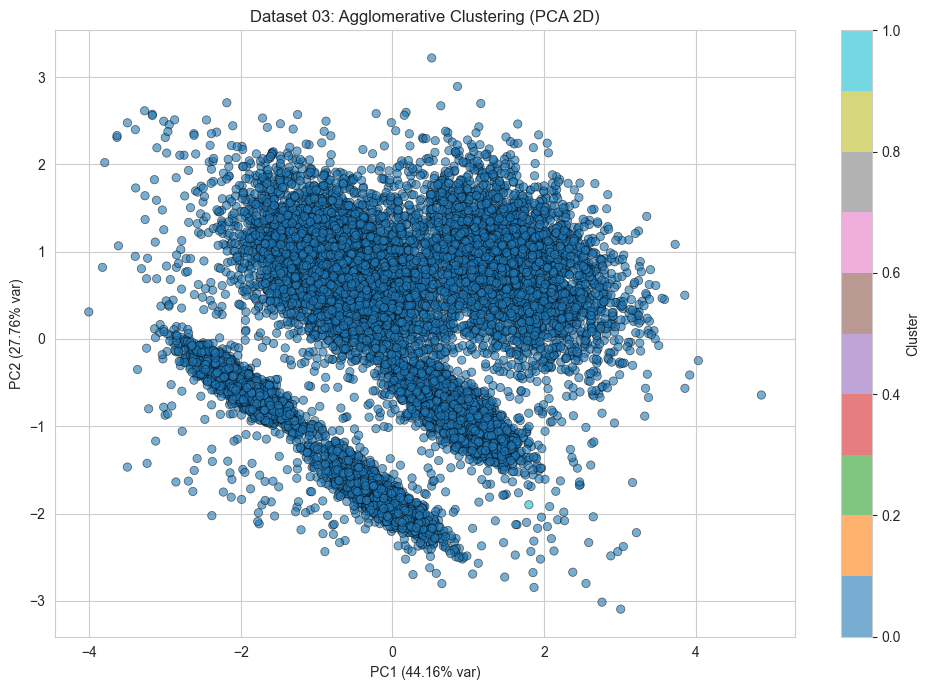

In [33]:
plot_clusters_pca(
    X3_scaled, 
    best_labels_3,
    f'Dataset 03: {best_method_3} Clustering (PCA 2D)',
    'artifacts/figures/ds03_best_clusters.png'
)

In [34]:
save_labels(sample_ids_3, best_labels_3, 'artifacts/labels/labels_hw07_ds03.csv')

Labels saved to artifacts/labels/labels_hw07_ds03.csv


## 5. Dataset 04: High Dimensionality + Categorical + Missing Values

This dataset requires careful preprocessing due to mixed data types and missing values.

### 5.1. Load and EDA

In [35]:
df4 = pd.read_csv('data/S07-hw-dataset-04.csv')

print("Dataset 04 - Shape:", df4.shape)
print("\nFirst rows:")
display(df4.head())

print("\nData types:")
print(df4.dtypes)

print("\nMissing values:")
missing_counts = df4.isnull().sum()
missing_pct = (missing_counts / len(df4)) * 100
missing_df = pd.DataFrame({'count': missing_counts, 'percentage': missing_pct})
display(missing_df[missing_df['count'] > 0])

print("\nBasic statistics:")
display(df4.describe())

Dataset 04 - Shape: (10000, 33)

First rows:


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676



Data types:
sample_id      int64
cat_a         object
cat_b         object
n01          float64
n02          float64
n03          float64
n04          float64
n05          float64
n06          float64
n07          float64
n08          float64
n09          float64
n10          float64
n11          float64
n12          float64
n13          float64
n14          float64
n15          float64
n16          float64
n17          float64
n18          float64
n19          float64
n20          float64
n21          float64
n22          float64
n23          float64
n24          float64
n25          float64
n26          float64
n27          float64
n28          float64
n29          float64
n30          float64
dtype: object

Missing values:


,count,percentage
n01,174,1.74
n02,189,1.89
n03,199,1.99
n04,192,1.92
n05,201,2.01
n06,183,1.83
n07,204,2.04
n08,194,1.94
n09,195,1.95
n10,189,1.89



Basic statistics:


,sample_id,n01,n02,n03,n04,n05,n06,n07,n08,n09,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
count,10000.00000,9826.000000,9811.000000,9801.000000,9808.000000,9799.000000,9817.000000,9796.000000,9806.000000,9805.000000,...,9785.000000,9804.000000,9829.000000,9793.000000,9815.000000,9776.000000,9803.000000,9789.000000,9798.000000,9805.000000
mean,4999.50000,17.348435,-2.057620,7.908302,14.269157,0.900590,5.832787,-0.840875,-4.888128,3.184200,...,-12.716502,-0.506241,8.360226,0.026943,0.039297,-0.037155,0.028512,-0.030738,-0.018685,-0.030254
std,2886.89568,22.578551,19.043410,25.637807,18.815319,20.981294,13.221646,26.583849,15.466271,32.208740,...,37.290305,14.336833,17.754646,26.121335,3.009995,3.020813,3.028106,3.000090,3.014209,3.014573
min,0.00000,-22.437090,-37.546998,-38.136412,-23.374316,-45.914070,-20.650038,-60.297304,-44.464550,-70.904880,...,-89.640783,-35.102360,-25.014050,-49.423300,-11.225848,-14.446922,-10.840777,-11.679259,-11.437909,-11.491223
25%,2499.75000,-3.975438,-14.200552,-8.591513,-1.223379,-5.086756,-4.532057,-13.554720,-17.352641,-11.460490,...,-41.284671,-11.563652,-2.123576,-19.425213,-1.973213,-2.082235,-2.007628,-2.074500,-2.051778,-2.074396
50%,4999.50000,22.042807,-6.532183,0.350400,10.069142,2.413111,7.391953,-2.429024,-7.095546,13.258691,...,-1.145681,2.491416,6.691365,-8.464171,0.037806,-0.033336,0.031588,-0.043127,-0.015441,-0.015903
75%,7499.25000,37.535647,2.092197,30.725630,29.807101,18.398883,13.033076,16.095731,3.909111,20.188426,...,18.916379,11.903004,14.939690,16.861978,2.048648,2.019027,2.056870,1.980217,2.013964,2.031215
max,9999.00000,65.446912,43.326647,60.185729,65.094588,42.527554,39.933274,48.591236,31.335431,64.696045,...,49.157087,22.452135,46.892903,61.540902,11.002135,11.394631,11.936846,10.663960,10.665988,13.755203


In [36]:
sample_ids_4 = df4['sample_id'].values
df4_work = df4.drop(columns=['sample_id'])

numeric_cols = df4_work.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df4_work.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_cols)}): {numeric_cols[:5]}...")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

Numeric features (30): ['n01', 'n02', 'n03', 'n04', 'n05']...
Categorical features (2): ['cat_a', 'cat_b']


### 5.2. Preprocessing with Pipeline

In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X4_scaled = preprocessor.fit_transform(df4_work)

print(f"Preprocessed shape: {X4_scaled.shape}")
print(f"Original shape: {df4_work.shape}")

Preprocessed shape: (10000, 42)
Original shape: (10000, 32)


### 5.3. KMeans - Hyperparameter Search

In [38]:
k_range = range(2, 21)
kmeans_results_4 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X4_scaled)
    metrics = compute_metrics(X4_scaled, labels)
    
    kmeans_results_4.append({
        'k': k,
        'silhouette': metrics['silhouette'],
        'davies_bouldin': metrics['davies_bouldin'],
        'calinski_harabasz': metrics['calinski_harabasz'],
        'inertia': kmeans.inertia_
    })

df_kmeans_4 = pd.DataFrame(kmeans_results_4)
display(df_kmeans_4.head(10))

,k,silhouette,davies_bouldin,calinski_harabasz,inertia
0,2,0.255503,1.635731,3126.328083,241233.648481
1,3,0.294128,1.466640,3355.136730,189481.119639
2,4,0.374888,1.164396,3907.022658,145756.149890
3,5,0.447369,0.975904,5087.688517,104300.573361
4,6,0.423134,1.009677,5371.618125,85877.431332
5,7,0.382654,1.659294,4566.924337,84623.216334
6,8,0.317996,2.104849,3990.988974,83422.605081
7,9,0.269358,2.460372,3559.693954,82244.154754
8,10,0.181547,2.788236,3223.850356,81105.610662
9,11,0.213340,2.725846,2938.402438,80338.766088


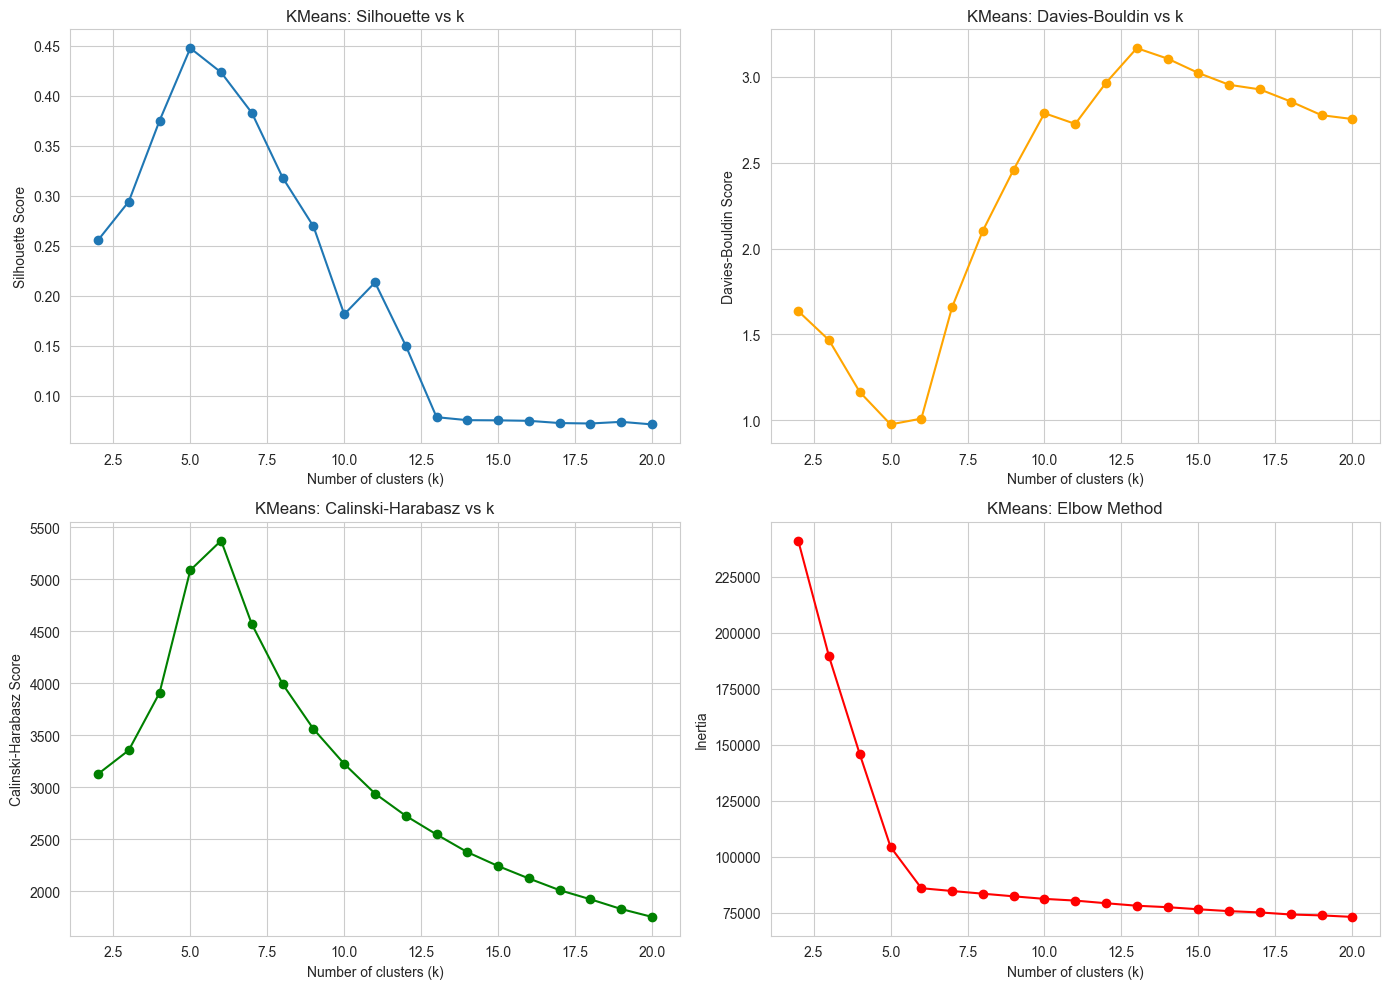

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(df_kmeans_4['k'], df_kmeans_4['silhouette'], 'o-')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('KMeans: Silhouette vs k')
axes[0, 0].grid(True)

axes[0, 1].plot(df_kmeans_4['k'], df_kmeans_4['davies_bouldin'], 'o-', color='orange')
axes[0, 1].set_xlabel('Number of clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Score')
axes[0, 1].set_title('KMeans: Davies-Bouldin vs k')
axes[0, 1].grid(True)

axes[1, 0].plot(df_kmeans_4['k'], df_kmeans_4['calinski_harabasz'], 'o-', color='green')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('KMeans: Calinski-Harabasz vs k')
axes[1, 0].grid(True)

axes[1, 1].plot(df_kmeans_4['k'], df_kmeans_4['inertia'], 'o-', color='red')
axes[1, 1].set_xlabel('Number of clusters (k)')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('KMeans: Elbow Method')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds04_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
best_k_4 = df_kmeans_4.loc[df_kmeans_4['silhouette'].idxmax(), 'k']
print(f"Best k (by silhouette): {best_k_4}")

kmeans_best_4 = KMeans(n_clusters=int(best_k_4), random_state=42, n_init=10)
labels_kmeans_4 = kmeans_best_4.fit_predict(X4_scaled)

metrics_kmeans_4 = compute_metrics(X4_scaled, labels_kmeans_4)
print(f"\nKMeans metrics (k={best_k_4}):")
for key, val in metrics_kmeans_4.items():
    print(f"  {key}: {val}")

Best k (by silhouette): 5

KMeans metrics (k=5):
  silhouette: 0.44736887827969146
  davies_bouldin: 0.975904265483746
  calinski_harabasz: 5087.688517434967
  n_clusters: 5
  noise_ratio: 0.0


### 5.4. Agglomerative Clustering - Hyperparameter Search

In [41]:
k_range_agg = range(2, 16)
linkage_methods = ['ward', 'complete', 'average']

agg_results_4 = []

for k in k_range_agg:
    for linkage in linkage_methods:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X4_scaled)
        metrics = compute_metrics(X4_scaled, labels)
        
        agg_results_4.append({
            'k': k,
            'linkage': linkage,
            'silhouette': metrics['silhouette'],
            'davies_bouldin': metrics['davies_bouldin'],
            'calinski_harabasz': metrics['calinski_harabasz']
        })

df_agg_4 = pd.DataFrame(agg_results_4)
display(df_agg_4.head(10))

,k,linkage,silhouette,davies_bouldin,calinski_harabasz
0,2,ward,0.255503,1.635731,3126.328083
1,2,complete,0.255503,1.635731,3126.328083
2,2,average,0.255503,1.635731,3126.328083
3,3,ward,0.294128,1.466640,3355.136730
4,3,complete,0.294128,1.466640,3355.136730
5,3,average,0.306091,1.434369,3303.379822
6,4,ward,0.374888,1.164396,3907.022658
7,4,complete,0.364593,1.255711,3796.040536
8,4,average,0.372104,1.119144,3739.606741
9,5,ward,0.447369,0.975904,5087.688517


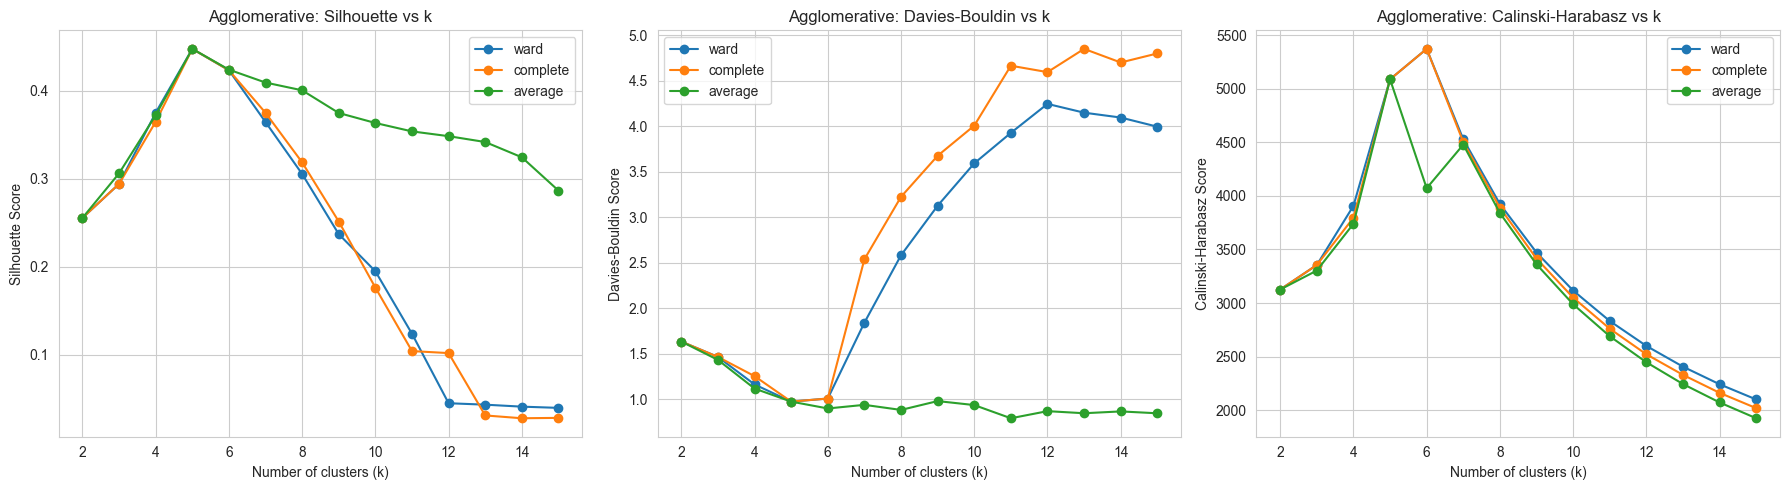

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for linkage in linkage_methods:
    subset = df_agg_4[df_agg_4['linkage'] == linkage]
    axes[0].plot(subset['k'], subset['silhouette'], 'o-', label=linkage)
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Agglomerative: Silhouette vs k')
axes[0].legend()
axes[0].grid(True)

for linkage in linkage_methods:
    subset = df_agg_4[df_agg_4['linkage'] == linkage]
    axes[1].plot(subset['k'], subset['davies_bouldin'], 'o-', label=linkage)
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Agglomerative: Davies-Bouldin vs k')
axes[1].legend()
axes[1].grid(True)

for linkage in linkage_methods:
    subset = df_agg_4[df_agg_4['linkage'] == linkage]
    axes[2].plot(subset['k'], subset['calinski_harabasz'], 'o-', label=linkage)
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Agglomerative: Calinski-Harabasz vs k')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds04_agg_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
best_idx_4 = df_agg_4['silhouette'].idxmax()
best_k_agg_4 = df_agg_4.loc[best_idx_4, 'k']
best_linkage_4 = df_agg_4.loc[best_idx_4, 'linkage']

print(f"Best Agglomerative params: k={best_k_agg_4}, linkage={best_linkage_4}")

agg_best_4 = AgglomerativeClustering(n_clusters=int(best_k_agg_4), linkage=best_linkage_4)
labels_agg_4 = agg_best_4.fit_predict(X4_scaled)

metrics_agg_4 = compute_metrics(X4_scaled, labels_agg_4)
print(f"\nAgglomerative metrics:")
for key, val in metrics_agg_4.items():
    print(f"  {key}: {val}")

Best Agglomerative params: k=5, linkage=ward

Agglomerative metrics:
  silhouette: 0.44736887827969146
  davies_bouldin: 0.975904265483746
  calinski_harabasz: 5087.688517434967
  n_clusters: 5
  noise_ratio: 0.0


### 5.5. Visualization and Best Model Selection

In [44]:
print("Comparison for Dataset 04:")
print(f"\nKMeans (k={best_k_4}):")
print(f"  Silhouette: {metrics_kmeans_4['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_kmeans_4['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_kmeans_4['calinski_harabasz']:.2f}")

print(f"\nAgglomerative (k={best_k_agg_4}, linkage={best_linkage_4}):")
print(f"  Silhouette: {metrics_agg_4['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_agg_4['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_agg_4['calinski_harabasz']:.2f}")

Comparison for Dataset 04:

KMeans (k=5):
  Silhouette: 0.4474
  Davies-Bouldin: 0.9759
  Calinski-Harabasz: 5087.69

Agglomerative (k=5, linkage=ward):
  Silhouette: 0.4474
  Davies-Bouldin: 0.9759
  Calinski-Harabasz: 5087.69


In [45]:
if metrics_agg_4['silhouette'] > metrics_kmeans_4['silhouette']:
    best_method_4 = 'Agglomerative'
    best_labels_4 = labels_agg_4
    best_params_4 = {'k': int(best_k_agg_4), 'linkage': best_linkage_4}
else:
    best_method_4 = 'KMeans'
    best_labels_4 = labels_kmeans_4
    best_params_4 = {'k': int(best_k_4)}

print(f"\nBest method for Dataset 04: {best_method_4}")
print(f"Best parameters: {best_params_4}")


Best method for Dataset 04: KMeans
Best parameters: {'k': 5}


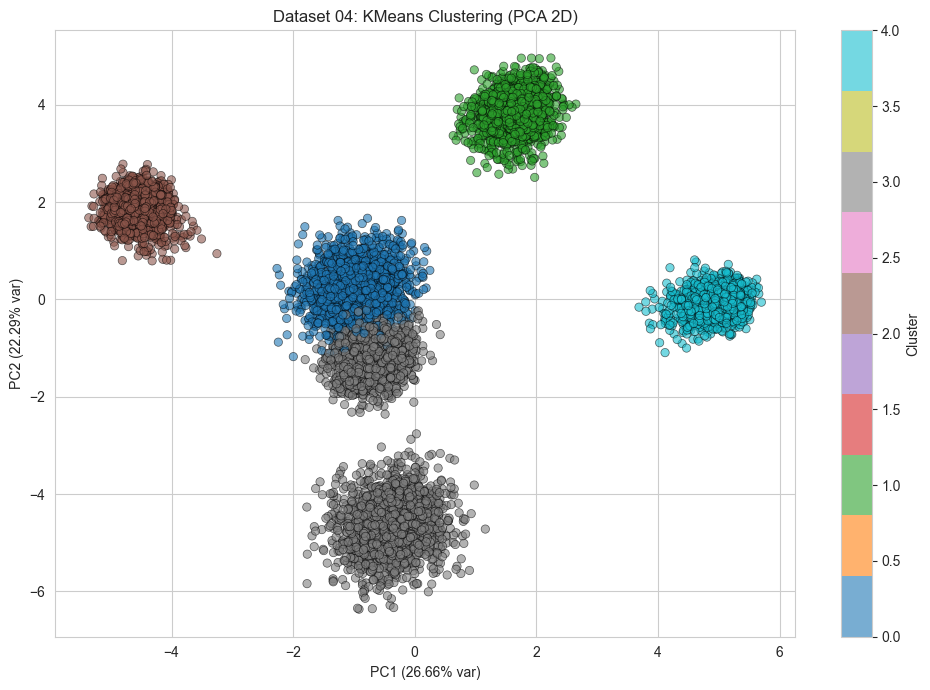

In [46]:
plot_clusters_pca(
    X4_scaled, 
    best_labels_4,
    f'Dataset 04: {best_method_4} Clustering (PCA 2D)',
    'artifacts/figures/ds04_best_clusters.png'
)

In [47]:
save_labels(sample_ids_4, best_labels_4, 'artifacts/labels/labels_hw07_ds04.csv')

Labels saved to artifacts/labels/labels_hw07_ds04.csv


## 6. Cluster Interpretation

In [48]:
print("Cluster Profile Analysis for Dataset 02")
print("="*60)

df2_with_clusters = df2.copy()
df2_with_clusters['cluster'] = best_labels_2

cluster_profiles = df2_with_clusters.groupby('cluster').mean()
display(cluster_profiles)

print("\nCluster sizes:")
print(df2_with_clusters['cluster'].value_counts().sort_index())

Cluster Profile Analysis for Dataset 02


,sample_id,x1,x2,z_noise
cluster,,,,
-1,430.800000,0.530640,0.329624,4.043858
0,4030.092032,0.478572,0.241092,0.073845
1,436.000000,0.137654,-1.622916,11.681131



Cluster sizes:
cluster
-1      65
 0    7932
 1       3
Name: count, dtype: int64


## 7. Export Summary Artifacts

In [49]:
metrics_summary = {
    'dataset_02': {
        'best_method': best_method_2,
        'best_params': best_params_2,
        'kmeans': {
            'k': int(best_k_2),
            'silhouette': float(metrics_kmeans_2['silhouette']),
            'davies_bouldin': float(metrics_kmeans_2['davies_bouldin']),
            'calinski_harabasz': float(metrics_kmeans_2['calinski_harabasz'])
        },
        'dbscan': {
            'eps': float(best_eps_2),
            'min_samples': int(best_min_samples_2),
            'silhouette': float(metrics_dbscan_2['silhouette']),
            'davies_bouldin': float(metrics_dbscan_2['davies_bouldin']),
            'calinski_harabasz': float(metrics_dbscan_2['calinski_harabasz']),
            'noise_ratio': float(metrics_dbscan_2['noise_ratio']),
            'n_clusters': int(metrics_dbscan_2['n_clusters'])
        }
    },
    'dataset_03': {
        'best_method': best_method_3,
        'best_params': best_params_3,
        'kmeans': {
            'k': int(best_k_3),
            'silhouette': float(metrics_kmeans_3['silhouette']),
            'davies_bouldin': float(metrics_kmeans_3['davies_bouldin']),
            'calinski_harabasz': float(metrics_kmeans_3['calinski_harabasz'])
        },
        'agglomerative': {
            'k': int(best_k_agg_3),
            'linkage': best_linkage_3,
            'silhouette': float(metrics_agg_3['silhouette']),
            'davies_bouldin': float(metrics_agg_3['davies_bouldin']),
            'calinski_harabasz': float(metrics_agg_3['calinski_harabasz'])
        }
    },
    'dataset_04': {
        'best_method': best_method_4,
        'best_params': best_params_4,
        'kmeans': {
            'k': int(best_k_4),
            'silhouette': float(metrics_kmeans_4['silhouette']),
            'davies_bouldin': float(metrics_kmeans_4['davies_bouldin']),
            'calinski_harabasz': float(metrics_kmeans_4['calinski_harabasz'])
        },
        'agglomerative': {
            'k': int(best_k_agg_4),
            'linkage': best_linkage_4,
            'silhouette': float(metrics_agg_4['silhouette']),
            'davies_bouldin': float(metrics_agg_4['davies_bouldin']),
            'calinski_harabasz': float(metrics_agg_4['calinski_harabasz'])
        }
    }
}

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print("Metrics summary saved to artifacts/metrics_summary.json")

Metrics summary saved to artifacts/metrics_summary.json


In [50]:
best_configs = {
    'dataset_02': {
        'method': best_method_2,
        'params': best_params_2,
        'selection_criterion': 'silhouette_score'
    },
    'dataset_03': {
        'method': best_method_3,
        'params': best_params_3,
        'selection_criterion': 'silhouette_score'
    },
    'dataset_04': {
        'method': best_method_4,
        'params': best_params_4,
        'selection_criterion': 'silhouette_score'
    }
}

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

print("Best configurations saved to artifacts/best_configs.json")

Best configurations saved to artifacts/best_configs.json
